<a href="https://colab.research.google.com/github/jefffang19/image_processing_final/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework requirement:
pytorch == 1.6.0

In [1]:
!python --version

Python 3.6.9


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [5]:
# if use google colab, mount your drive

from google.colab import drive
drive.mount('/content/gdrive')

dataset_path = F"/content/gdrive/My Drive/ip_final/data/train"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# The structure of the dataset

```
0 (patient)
  |
  | -|- CT => mask
     |- FT => mask
     |- MN => mask
     |- T1 => input image 1
     |- T2 => input image 2
```



In [6]:
import cv2
import matplotlib.pyplot as plt
import os

# Define dataset

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np

In [35]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        task (str): which task to do
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
            task='CT', # CT, FT, MN
            augmentation=None, 
            preprocessing=None,
    ):
        self.patientId = sorted(os.listdir(path))
        self.num_imgs_of_each_pat = [] # count number of images for each patient
        self.ct = []
        self.ft = []
        self.mn = []
        self.t1 = []
        self.t2 = []

        # append file path
        for i in self.patientId:
          # append each class of images
          _cts = sorted(os.listdir('{}/{}/CT/'.format(path, i)), reverse=True)
          _cts = ['{}/{}/CT/{}'.format(path, i, j) for j in _cts]
          self.ct.append(_cts)
          _fts = sorted(os.listdir('{}/{}/FT/'.format(path, i)), reverse=True)
          _fts = ['{}/{}/FT/{}'.format(path, i, j) for j in _fts]
          self.ft.append(_fts)
          _mns = sorted(os.listdir('{}/{}/MN/'.format(path, i)), reverse=True)
          _mns = ['{}/{}/MN/{}'.format(path, i, j) for j in _mns]
          self.mn.append(_mns)
          _t1s = sorted(os.listdir('{}/{}/T1/'.format(path, i)), reverse=True)
          _t1s = ['{}/{}/T1/{}'.format(path, i, j) for j in _t1s]
          self.t1.append(_t1s)
          _t2s = sorted(os.listdir('{}/{}/T2/'.format(path, i)), reverse=True)
          _t2s = ['{}/{}/T2/{}'.format(path, i, j) for j in _t2s]
          self.t2.append(_t2s)

          # count number of images in each patient
          self.num_imgs_of_each_pat.append(len(_cts))
          

        # debug
        # print(self.ct)
        # print(self.ft)
        # print(self.mn)
        # print(self.t1)
        # print(self.t2)
        # print(self.num_imgs_of_each_pat)


        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        # count number i in which patient
        i_img = i
        pat = 0
        for n, max_value in enumerate(self.num_imgs_of_each_pat):
          if i_img < max_value:
            break
          else:
            i_img -= max_value
            pat += 1
          
          # if i still bigger than the last images number, raise error
          if n == len(self.num_imgs_of_each_pat) - 1:
            raise 'Dataset index out of range !'

        # debug
        # print(self.t1[pat][i_img])
        # print(self.t2[pat][i_img])
        # print(self.ct[pat][i_img])
        # print(self.ft[pat][i_img])
        # print(self.mn[pat][i_img])

        # now we know we want to get
        # patient id: pat
        # image #: i_img
        
        # read img
        image_t1 = cv2.imread(self.t1[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # image = cv2.resize(image, (800, 640)) # image size of multiple of 2^network_depth ie. 32px
        image_t2 = cv2.imread(self.t2[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ct = cv2.imread(self.ct[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ft = cv2.imread(self.ft[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_mn = cv2.imread(self.mn[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (800, 640)) # iamge size of multiple of 2^network_depth ie. 32px

        # debug
        # print(image_t1.shape)
        # print(image_t2.shape)
        # print(mask_ct.shape)
        # print(mask_ft.shape)
        # print(mask_mn.shape)


        # stack the images and masks
        image = np.stack((image_t1, image_t2), axis=2)
        mask = np.stack((mask_ct, mask_ft, mask_mn), axis=2)
        
        
        # apply augmentations
        if self.augmentation:
            # 3 channel needed to use augmentation
            # so we pad a channel for image
            _image = np.stack((image[...,0], image[...,1], np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)), axis=2)
            sample = self.augmentation(image=_image, mask=mask)
            _image, mask = sample['image'], sample['mask']

            # assign the first two channel back
            image = np.stack((_image[...,0], _image[...,1]), axis=2)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # normalize needs to be done or training evalutation will be wrong
        # normalize needs to do after augmentations, or will cause error
        image = image/255 # normalize image
        mask = mask/255 # normalize image
            
        return image, mask
        
    def __len__(self):
        return np.sum(self.num_imgs_of_each_pat)

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
train_set = Dataset(dataset_path)

In [11]:
# number of sets of imgs and labels (t1, t2, ct, ft, mn)
len(train_set)

189

In [12]:
image, mask = train_set[40]

print(image.shape, mask.shape)

/content/gdrive/My Drive/ip_final/data/train/1/T1/0.jpg
/content/gdrive/My Drive/ip_final/data/train/1/T2/0.jpg
/content/gdrive/My Drive/ip_final/data/train/1/CT/0.jpg
/content/gdrive/My Drive/ip_final/data/train/1/FT/0.jpg
/content/gdrive/My Drive/ip_final/data/train/1/MN/0.jpg
(512, 512)
(512, 512)


AttributeError: ignored

In [ ]:
# visual data
visualize(
    t1=image[...,0],
    t2=image[...,1],
    mask_stacked=mask,
    ct=mask[...,0],
    ft=mask[...,1],
    mn=mask[...,2]
)

# preprocess & data augmentation

In [ ]:
import albumentations as albu

def get_training_augmentation():
    # TODO: keep augmentation suitable for medical image
    train_transform = [

      albu.HorizontalFlip(p=0.5),

      albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      albu.RandomCrop(height=320, width=320, always_apply=True),

      albu.IAAAdditiveGaussianNoise(p=0.2),
      albu.IAAPerspective(p=0.5),

      albu.OneOf(
          [
              albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
          ],
          p=0.9,
      ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [ ]:
#### Visualize augmented images and masks

augmented_trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_trainset[60]
    # visual data
    visualize(
        t1=image[...,0],
        t2=image[...,1],
        mask_stacked=mask,
        ct=mask[...,0],
        ft=mask[...,1],
        mn=mask[...,2]
    )

# create model

In [13]:
# Download segmentation model pytorch
!pip install segmentation-models-pytorch

U-Net++

docs:
https://smp.readthedocs.io/en/latest/models.html#id2

```
segmentation_models_pytorch.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None)
```



In [14]:
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('using gpu')
  DEVICE = 'cuda'
else:
  print('using cpu')

# our input:
# t1, t2 stacked
# our output has 3 classes (ct, ft, mn)
# because our mask has overlay, so we should not use softmax at last layer activation
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')

using cpu


In [33]:
!pip install torchsummary

In [34]:
from torchsummary import summary

if torch.cuda.is_available():
  summary(model.cuda(), (2, 576, 576))
else:
  summary(model, (2, 576, 576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           6,272
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

# 5 fold cross-validation is required

In [ ]:
trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing_no_pretrain(),
)

In [ ]:
def trainLoaders(*datasets, batch_size=32):
  loaders = []
  for i in datasets:
    loaders.append(torch.utils.data.DataLoader(i, batch_size=batch_size, shuffle=True, num_workers=12))
  
  return loaders

In [ ]:
#split the training dataset into 5 fold
len_trainset_1_4 = len(trainset)//5
# the last fold
len_trainset_5 = len(trainset)%len_trainset_1_4 + len_trainset_1_4

training_sets = torch.utils.data.random_split(trainset, [len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_5])
training_loaders = trainLoaders(*training_sets)

In [ ]:
training_loaders

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
save_model_path = '/content/gdrive/My Drive/ip_final'

# Dice loss and Dice Score

https://zhuanlan.zhihu.com/p/86704421

## dice loss = 1 - dice score

In [ ]:
five_fold_dice = {
    0: [], 1: [], 2: [], 3: [], 4: []
}

EPOCH = 100


In [ ]:
!nvidia-smi

Thu Dec 17 02:59:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |   3423MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#5-fold validation
#let the k-th trainloader be the validation
for k in range(5):
  print('\nfold #{} as valid'.format(k))
  for n_fold in range(5):
    print('\ntrain fold #{}'.format(n_fold))
    #do not train the validation data
    if(n_fold == k):
      print('fold #{} is validation, skip'.format(n_fold))
      continue
    
     # train model for N epochs
    max_score = 0

    for i in range(EPOCH):
        
        print('\nEpoch: {}'.format(i))

        train_logs = train_epoch.run(training_loaders[n_fold])
        valid_logs = valid_epoch.run(training_loaders[k])

        # save dice of each fold
        five_fold_dice[n_fold].append(1 - valid_logs['dice_loss'])

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['dice_loss']:
            max_score = valid_logs['dice_loss']
            torch.save(model.state_dict(), save_model_path + '/fold{}_best_model.pth'.format(n_fold))
            print('Model saved!')
            
        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

串流輸出內容已截斷至最後 5000 行。

Epoch: 75
valid: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, dice_loss - 0.8036, iou_score - 0.4256]

Epoch: 76
valid: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, dice_loss - 0.7964, iou_score - 0.4387]

Epoch: 77
valid: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, dice_loss - 0.8096, iou_score - 0.4475]

Epoch: 78
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.8058, iou_score - 0.4234]

Epoch: 79
valid: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, dice_loss - 0.8167, iou_score - 0.4276]

Epoch: 80
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.802, iou_score - 0.4341]

Epoch: 81
valid: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, dice_loss - 0.8029, iou_score - 0.4448]

Epoch: 82
valid: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, dice_loss - 0.7928, iou_score - 0.46]

Epoch: 83
valid: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, dice_loss - 0.7978, iou_score - 0.4425]

Epoch: 84
valid: 100%|██████████| 2/2 [00:02<

In [ ]:
five_fold_dice

{0: [0.12107282876968384,
  0.13234975934028625,
  0.16266125440597534,
  0.14404726028442383,
  0.14228230714797974,
  0.14116734266281128,
  0.11322268843650818,
  0.12712690234184265,
  0.1391759216785431,
  0.13488680124282837,
  0.15999683737754822,
  0.12434622645378113,
  0.1522553563117981,
  0.12721842527389526,
  0.1577334702014923,
  0.14476755261421204,
  0.12073266506195068,
  0.15119850635528564,
  0.14594733715057373,
  0.12272435426712036,
  0.13524553179740906,
  0.11890038847923279,
  0.13185849785804749,
  0.14749589562416077,
  0.1381700336933136,
  0.1350502073764801,
  0.14413350820541382,
  0.13055145740509033,
  0.1464250087738037,
  0.15858709812164307,
  0.13438886404037476,
  0.1443360447883606,
  0.12762585282325745,
  0.15114262700080872,
  0.10386654734611511,
  0.16243994235992432,
  0.14578121900558472,
  0.1326502561569214,
  0.1521652340888977,
  0.15827012062072754,
  0.1261187195777893,
  0.15578129887580872,
  0.11536845564842224,
  0.13607940077781

## load trained model

In [15]:
load_model_path = F"/content/gdrive/My Drive/ip_final/fold4_best_model.pth"

In [16]:
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')
model.load_state_dict(torch.load(load_model_path, map_location='cpu'))

<All keys matched successfully>

# see result

In [17]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
)

/content/gdrive/My Drive/ip_final/data/test/9/T1/8.jpg
/content/gdrive/My Drive/ip_final/data/test/9/T2/8.jpg
/content/gdrive/My Drive/ip_final/data/test/9/CT/8.jpg
/content/gdrive/My Drive/ip_final/data/test/9/FT/8.jpg
/content/gdrive/My Drive/ip_final/data/test/9/MN/8.jpg
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


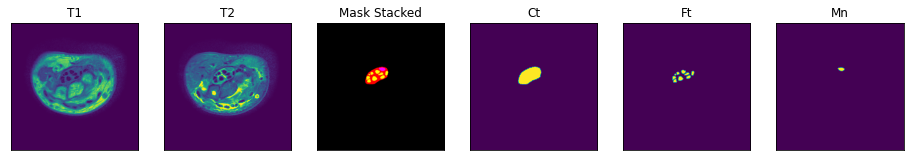

In [18]:
x, y = testset[1]

# visual input data and mask
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2]
)

## convert numpy to tensor

In [19]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

In [20]:
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)

# convert to tensor
image_tensor = transform(_x)

# take the first two images
image_tensor = image_tensor[0:2]

# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)

# cast to float
image_tensor = image_tensor.float()

image_tensor.shape

torch.Size([1, 2, 512, 512])

## fit model

In [21]:
model.eval()

pred = model(image_tensor)

pred.shape

torch.Size([1, 3, 512, 512])

## convert tensor to numpy

In [22]:
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()

# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

np_pred.shape

(512, 512, 3)

## show the predicted result

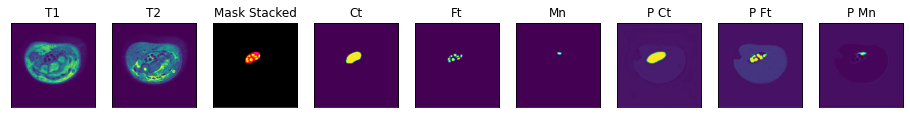

In [23]:
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

## evaluate
https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/metrics.py

In [24]:
import segmentation_models_pytorch.utils.metrics as metrics

In [25]:
# transfrom groundtruth to tensor
_y = transform(y)
_y = _y.unsqueeze(0)
_y.shape

torch.Size([1, 3, 512, 512])

In [26]:
# IoU
metrics.IoU()(pred, _y)

tensor(0.7072, dtype=torch.float64)

In [168]:
# Dice Score
metrics.Fscore()(pred, _y)

tensor(0.8712, dtype=torch.float64)

## evaluate ct ft mn seperatly

In [27]:
# get each layer by
pred[:, 1, ...].shape

torch.Size([1, 512, 512])

In [28]:
print('ct iou')
print(metrics.IoU()(pred[:, 0, ...], _y[:, 0, ...]))
print('ct dice')
print(metrics.Fscore()(pred[:, 0, ...], _y[:, 0, ...]))
print('ft iou')
print(metrics.IoU()(pred[:, 1, ...], _y[:, 1, ...]))
print('ft dice')
print(metrics.Fscore()(pred[:, 1, ...], _y[:, 1, ...]))
print('mn iou')
print(metrics.IoU()(pred[:, 2, ...], _y[:, 2, ...]))
print('mn dice')
print(metrics.Fscore()(pred[:, 2, ...], _y[:, 2, ...]))

ct iou
tensor(0.7902, dtype=torch.float64)
ct dice
tensor(0.8828, dtype=torch.float64)
ft iou
tensor(0.5744, dtype=torch.float64)
ft dice
tensor(0.7297, dtype=torch.float64)
mn iou
tensor(0.4760, dtype=torch.float64)
mn dice
tensor(0.6450, dtype=torch.float64)


## evalute each test data

In [29]:
import segmentation_models_pytorch.utils.metrics as metrics

In [36]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
)

In [37]:
len(testset)

18

In [38]:
for i in range(len(testset)):
  x, y = testset[i]
  # pad to three dimension so we can use transform
  _x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
  # convert to tensor
  image_tensor = transform(_x)
  # take the first two images
  image_tensor = image_tensor[0:2]
  # make batch size == 1
  image_tensor = image_tensor.unsqueeze(0)
  # cast to float
  image_tensor = image_tensor.float()
  # fit model
  model.eval()
  pred = model(image_tensor)
  # convert tensor to numpy
  np_pred = pred.detach().cpu().numpy().squeeze()
  # switch axis
  np_pred = np.transpose(np_pred, (1, 2, 0))
  # transfrom groundtruth to tensor
  _y = transform(y)
  _y = _y.unsqueeze(0)
  
  # print each image
  print('{}'.format(i))
  # print('ct iou')
  # print(metrics.IoU()(pred[:, 0, ...], _y[:, 0, ...]))
  print('ct dice', end='  ')
  print(metrics.Fscore()(pred[:, 0, ...], _y[:, 0, ...]))
  # print('ft iou')
  # print(metrics.IoU()(pred[:, 1, ...], _y[:, 1, ...]))
  print('ft dice', end='  ')
  print(metrics.Fscore()(pred[:, 1, ...], _y[:, 1, ...]))
  # print('mn iou')
  # print(metrics.IoU()(pred[:, 2, ...], _y[:, 2, ...]))
  print('mn dice', end='  ')
  print(metrics.Fscore()(pred[:, 2, ...], _y[:, 2, ...]))
  print('\n')


0
ct dice  tensor(0.9369, dtype=torch.float64)
ft dice  tensor(0.7639, dtype=torch.float64)
mn dice  tensor(0.5606, dtype=torch.float64)


1
ct dice  tensor(0.8828, dtype=torch.float64)
ft dice  tensor(0.7297, dtype=torch.float64)
mn dice  tensor(0.6450, dtype=torch.float64)


2
ct dice  tensor(0.8621, dtype=torch.float64)
ft dice  tensor(0.7461, dtype=torch.float64)
mn dice  tensor(0.6242, dtype=torch.float64)


3
ct dice  tensor(0.8827, dtype=torch.float64)
ft dice  tensor(0.7493, dtype=torch.float64)
mn dice  tensor(0.6647, dtype=torch.float64)


4
ct dice  tensor(0.9102, dtype=torch.float64)
ft dice  tensor(0.7580, dtype=torch.float64)
mn dice  tensor(0.7379, dtype=torch.float64)


5
ct dice  tensor(0.8907, dtype=torch.float64)
ft dice  tensor(0.8235, dtype=torch.float64)
mn dice  tensor(0.4614, dtype=torch.float64)


6
ct dice  tensor(0.8770, dtype=torch.float64)
ft dice  tensor(0.8061, dtype=torch.float64)
mn dice  tensor(0.5462, dtype=torch.float64)


7
ct dice  tensor(0.8542, d

## discussion
mn seems to be the hardest task
last compare worst mn and best mn result

In [39]:
x, y = testset[4]
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
# convert to tensor
image_tensor = transform(_x)
# take the first two images
image_tensor = image_tensor[0:2]
# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)
# cast to float
image_tensor = image_tensor.float()
# fit model
model.eval()
pred = model(image_tensor)
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()
# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

best mn dice


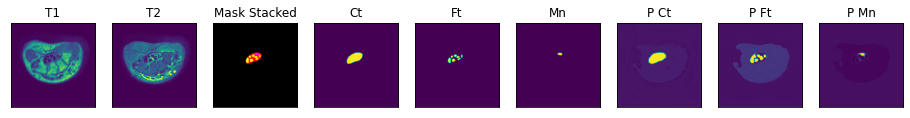

In [40]:
print('best mn dice')
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)

In [41]:
x, y = testset[8]
# pad to three dimension so we can use transform
_x = np.stack((x[...,0], x[...,1], np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)), axis=2)
# convert to tensor
image_tensor = transform(_x)
# take the first two images
image_tensor = image_tensor[0:2]
# make batch size == 1
image_tensor = image_tensor.unsqueeze(0)
# cast to float
image_tensor = image_tensor.float()
# fit model
model.eval()
pred = model(image_tensor)
# convert tensor to numpy
np_pred = pred.detach().cpu().numpy().squeeze()
# switch axis
np_pred = np.transpose(np_pred, (1, 2, 0))

worst mn dice


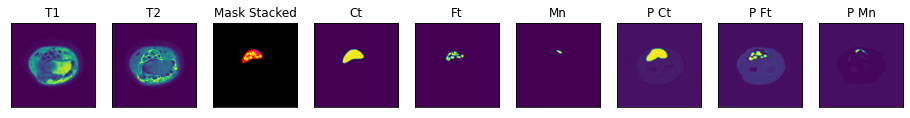

In [42]:
print('worst mn dice')
# visual input data and mask and predict result
visualize(
    t1=x[...,0],
    t2=x[...,1],
    mask_stacked=y,
    ct=y[...,0],
    ft=y[...,1],
    mn=y[...,2],
    p_ct=np_pred[..., 0],
    p_ft=np_pred[..., 1],
    p_mn=np_pred[..., 2],
)